In [1]:
import Modules.SQcircuit_extensions as sq_ext
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl
import importlib
import os
import sys

importlib.reload(sq_ext)

<module 'Modules.SQcircuit_extensions' from 'C:\\Users\\gabri\\PycharmProjects\\tunable-capacitive-coupling-flux-qubits\\Modules\\SQcircuit_extensions.py'>

# Single qubit

This notebook studies the circuit proposed by KIT. It consists on two qubits coupled by a third qubit. It's lumped element model is:
<img src='Other/qubit-qubit-qubit.jpg' width='500'>


## Define the circuit

In [42]:
# Circuit parameters
Csh = 15
C   = 15
CJ  = 3
Cc = 20
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0

# Initialize loop(s)
loop1 = sq.Loop(0.0)  # "Value" corresponds to phiExt / phi0 threading the loop (can change later)
loop2 = sq.Loop(0.0)
loop3 = sq.Loop(0.0)

# Circuit elements
# Elements for the three qubits decoupled
C_01, C_02, C_12, L_03, L_31, L_23, JJ = [[] for _ in range(7)]
for loop in [loop1, loop2, loop3]:
    C_01.append(sq.Capacitor(C,       'fF'))
    C_02.append(sq.Capacitor(C,       'fF'))
    C_12.append(sq.Capacitor(CJ+Csh,  'fF'))
    L_03.append(sq.Inductor(Lr,       'nH'))
    L_31.append(sq.Inductor(Lq/2 - Δ, 'nH', loops=[loop]))
    L_23.append(sq.Inductor(Lq/2 + Δ, 'nH', loops=[loop]))
    JJ  .append(sq.Junction(EJ,      'GHz', loops=[loop]))

# Capacitors for coupling
C_coupling = sq.Capacitor(Cc, 'fF')
C_ground = sq.Capacitor(Cc, 'fF')

# Create the circuit
elements = {
    # qubit 1, nodes [0, 1, 2, 3]
    (0, 3): [L_03[0]],
    (0, 1): [C_01[0]],
    (0, 2): [C_02[0]],
    (3, 1): [L_31[0]],
    (1, 2): [C_12[0], JJ[0]],
    (2, 3): [L_23[0]],
    # qubit 2, nodes [4, 5, 6, 7]
    # (4, 7): [L_03[1]],
    # (4, 5): [C_01[1]],
    # (4, 6): [C_02[1]],
    # (7, 5): [L_31[1]],
    # (5, 6): [C_12[1], JJ[1]],
    # (6, 7): [L_23[1]],
    # # qubit 3, nodes [8, 9, 10, 11]
    # (8, 11):  [L_03[2]],
    # (8, 9):   [C_01[2]],
    # (8, 10):  [C_02[2]],
    # (11, 9):  [L_31[2]],
    # (9, 10):  [C_12[2], JJ[2]],
    # (10, 11): [L_23[2]],
    # capacitive coupling
    # (2, 5): [C_coupling],
    # (6, 9): [C_coupling],
}

qubit = sq.Circuit(elements)

qubit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Analyze the convergence of truncation numbers vs external flux

[1, 2, 8] [ 6.70729176  8.65462735 12.87915103 13.9180083  15.86641765] 0.0007937496033383364


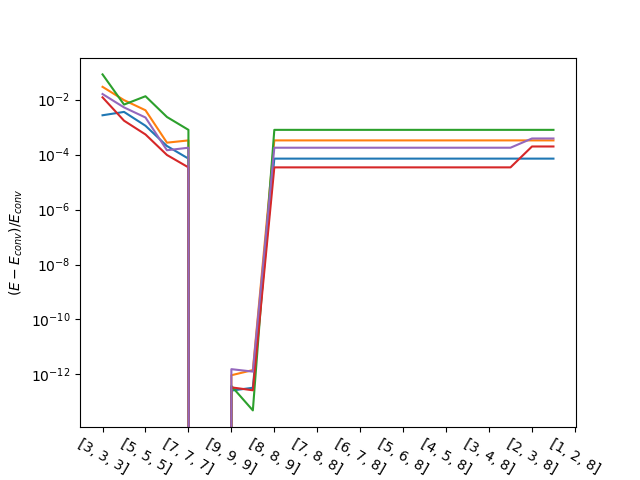

[[1, 2, 8], [1, 3, 9], [1, 3, 10]]


In [52]:
# external flux for sweeping over
phi = np.linspace(0.5,1,50)

# spectrum of the circuit
n_eig=5
spec = np.zeros((n_eig, len(phi)))

# calculate truncation numbers for initial, mid and final value of external flux.
trunc_vs_phi = []
loop.set_flux(phi[0])
qubit = sq_ext.truncation_convergence(qubit, n_eig, plot=True)
trunc_vs_phi.append(qubit.m)

loop.set_flux(phi[len(phi)//2])
qubit = sq_ext.truncation_convergence(qubit, n_eig, trunc_nums=qubit.m)
trunc_vs_phi.append(qubit.m)

loop.set_flux(phi[-1])
qubit = sq_ext.truncation_convergence(qubit, n_eig, trunc_nums=qubit.m)
trunc_vs_phi.append(qubit.m)

print(trunc_vs_phi)

## Spectrum vs external flux

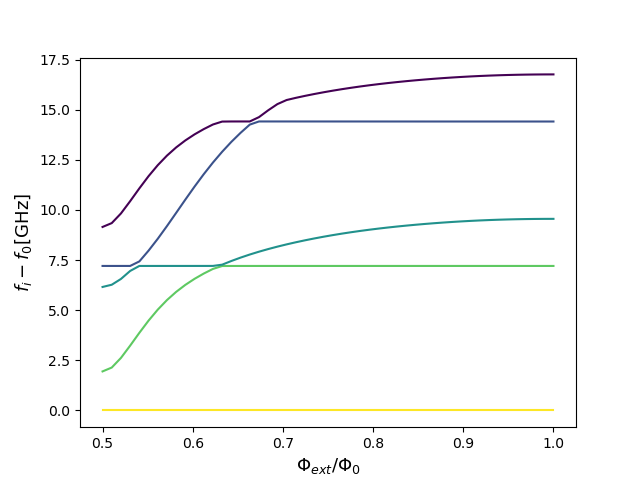

In [55]:
qubit.set_trunc_nums([1, 3, 10])

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))

for i in range(len(phi)):
    # set the external flux for the loop
    loop.set_flux(phi[i])
    # diagonlize the circuit
    spec[:, i] = qubit.diag(n_eig)[0]

plt.figure()
for i in range(n_eig):
    plt.plot(phi, spec[i,:]- spec[0,:], color=eig_colors[i])

plt.xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
plt.ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
plt.show()

## Eigenstates in phase base

In [48]:
# creat the phase grid
phi1 = 0
phi2 = np.linspace(-0.01, 0.01, 100)
phi3 = np.linspace(-0.5, 0.5  , 100)
grid = [phi1, phi2, phi3]

state0_vs_ext_flux = []
state1_vs_ext_flux = []
state2_vs_ext_flux = []
state3_vs_ext_flux = []

ext_flux_list = [0.5, 0.55, 0.65, 1]
# loop thorugh several values of external flux
for ext_flux in ext_flux_list:
    loop.set_flux(ext_flux)
    _, _ = qubit.diag(n_eig=5)

    # Calculate eigenstates in phase coord
    state0_vs_ext_flux.append(qubit.eig_phase_coord(0, grid=grid))
    state1_vs_ext_flux.append(qubit.eig_phase_coord(1, grid=grid))
    state2_vs_ext_flux.append(qubit.eig_phase_coord(2, grid=grid))
    state3_vs_ext_flux.append(qubit.eig_phase_coord(3, grid=grid))

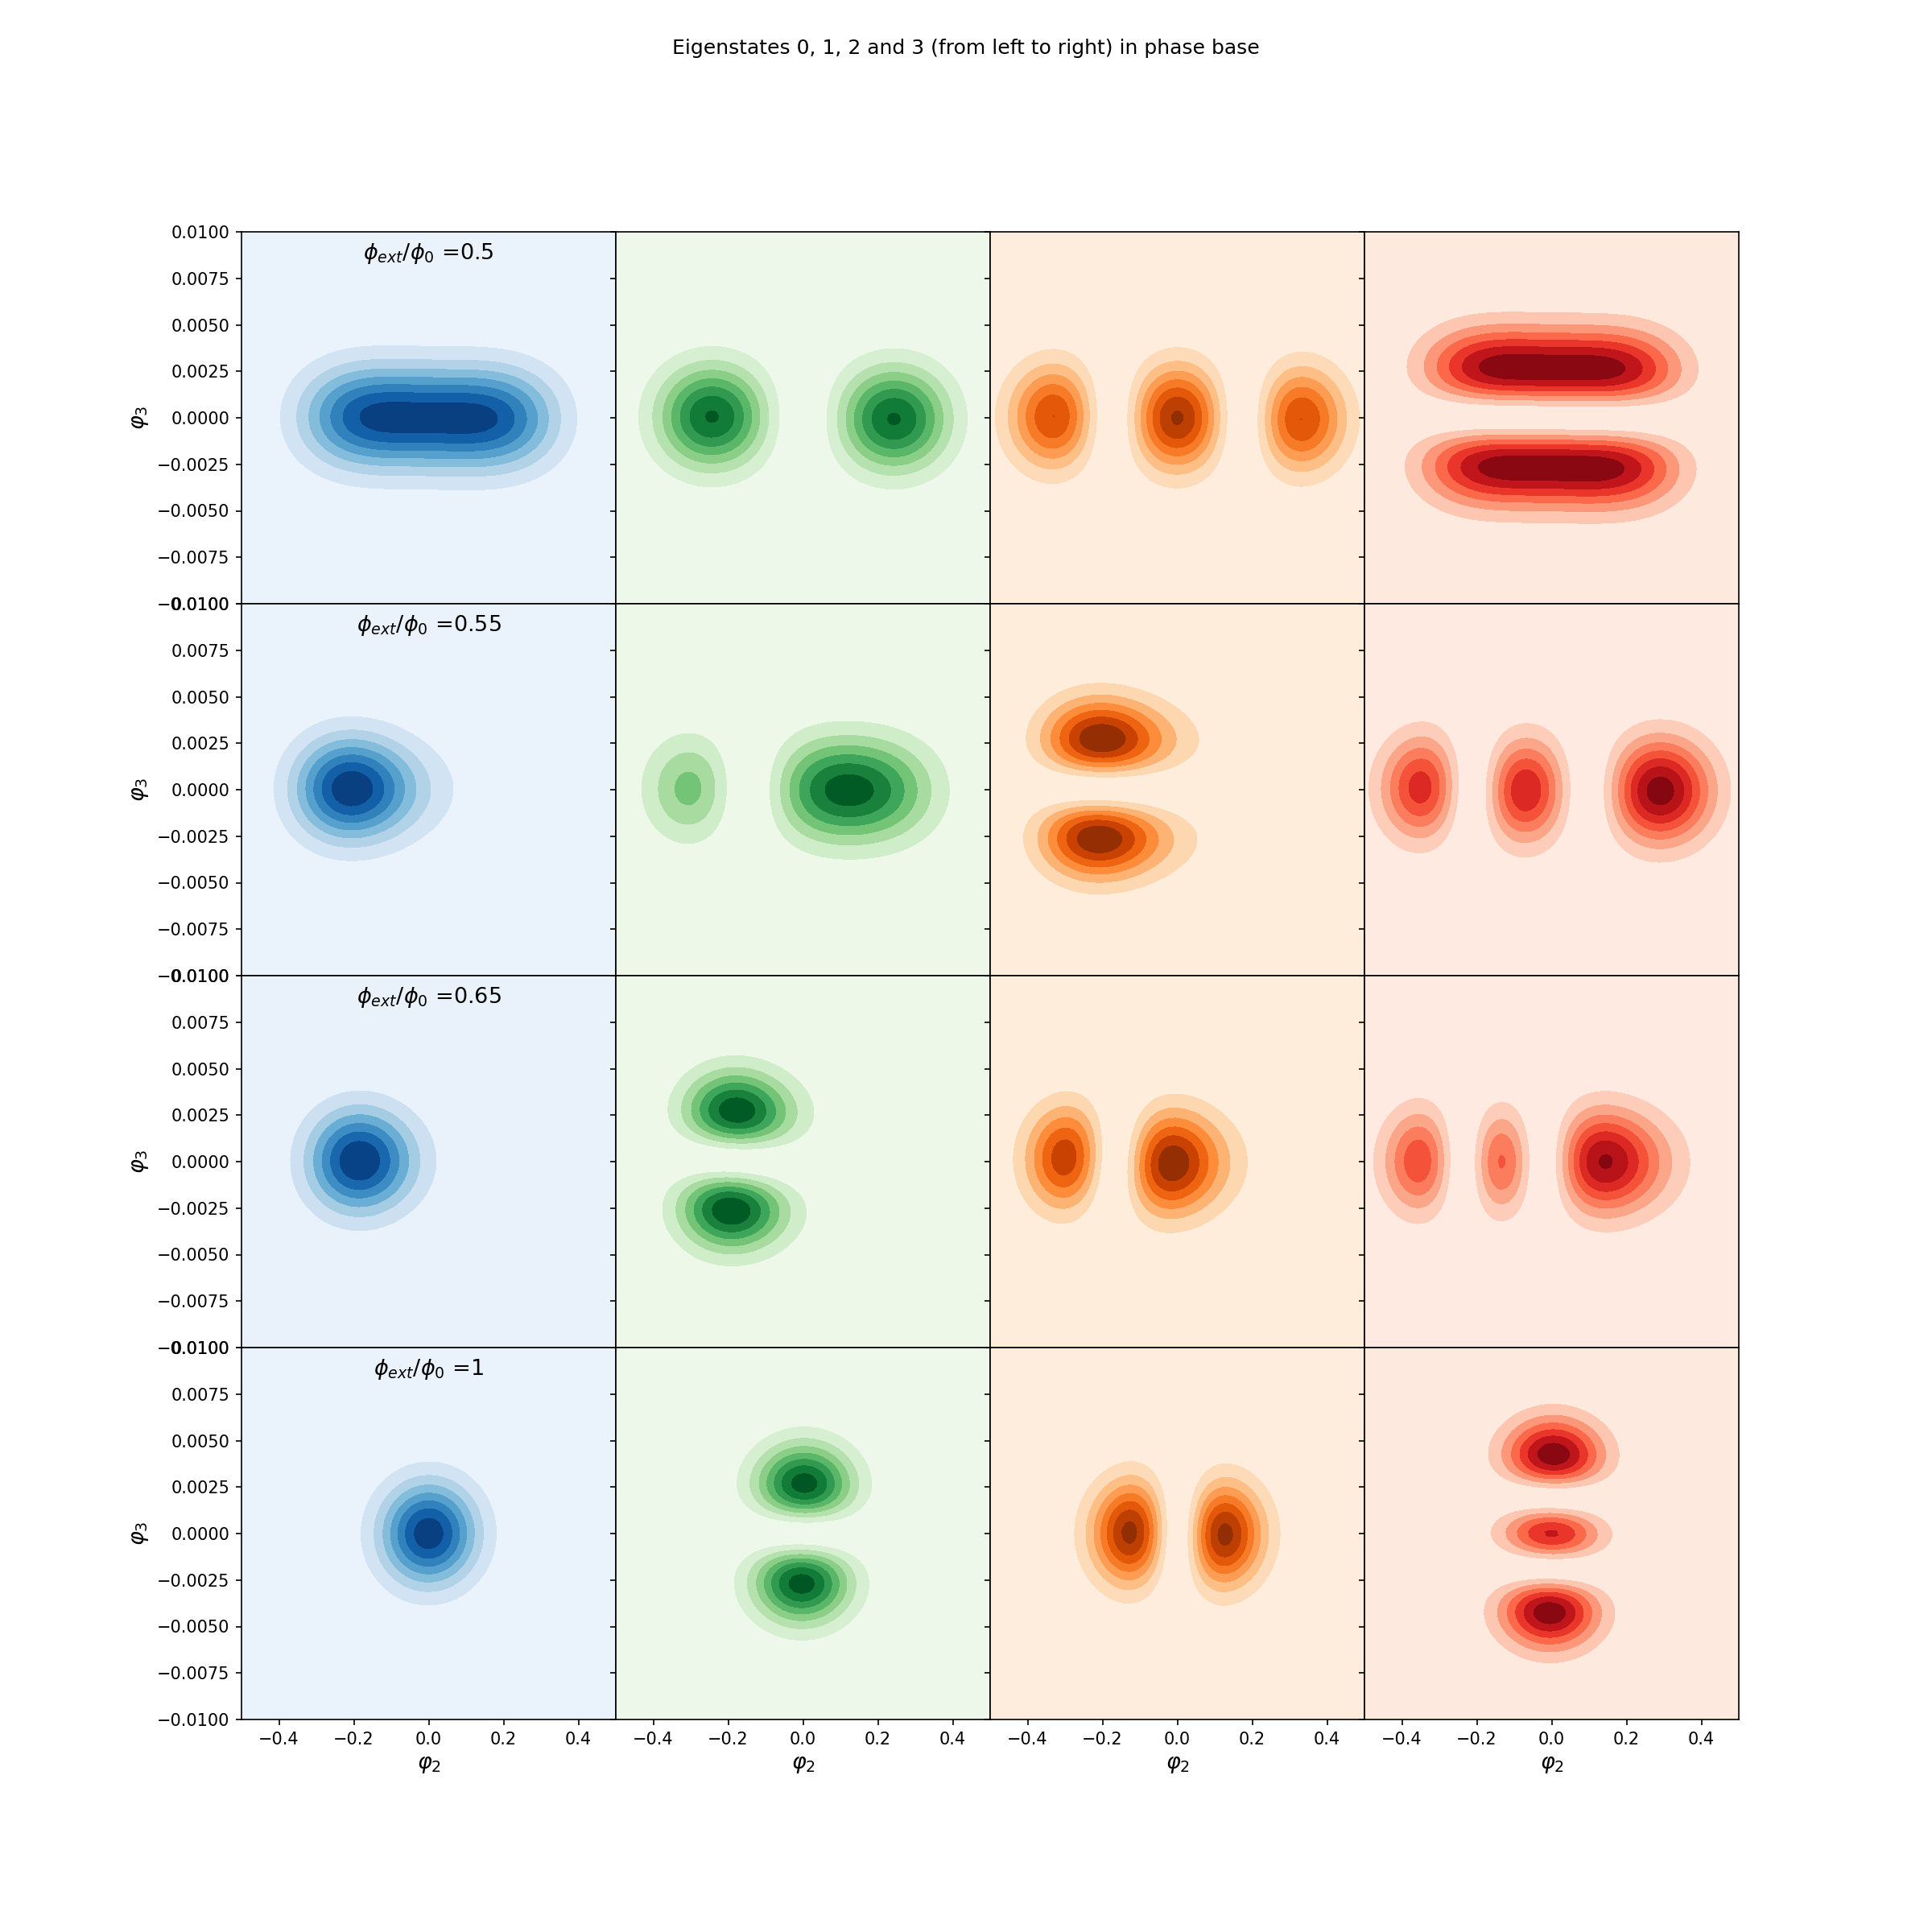

In [67]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4), sharey='row', sharex = 'col', dpi=150)

for i, ext_flux in enumerate(ext_flux_list):
    axs[i, 0].contourf(phi3, phi2, np.abs(state0_vs_ext_flux[i].T) ** 2, cmap="Blues", )
    axs[i, 1].contourf(phi3, phi2, np.abs(state1_vs_ext_flux[i].T) ** 2, cmap="Greens" )
    axs[i, 2].contourf(phi3, phi2, np.abs(state2_vs_ext_flux[i].T) ** 2, cmap="Oranges")
    axs[i, 3].contourf(phi3, phi2, np.abs(state3_vs_ext_flux[i].T) ** 2, cmap="Reds"   )
    for j in range(4):
        axs[-1, j].set_xlabel(r"$\varphi_2$", fontsize=13)
    axs[i, 0].set_ylabel(r"$\varphi_3$", fontsize=13)
    axs[i, 0].set_title('$\phi_{ext}/\phi_{0}$ ='+f'{ext_flux}', fontsize=13, y=0.9 )
fig.suptitle('Eigenstates 0, 1, 2 and 3 (from left to right) in phase base')
plt.subplots_adjust(wspace=0)
plt.subplots_adjust(hspace=0)
plt.show()